In [49]:
import numpy as np
from numpy import concatenate
import pandas as pd
import tensorflow as tf
import keras
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [43]:
solar_data = pd.read_csv('train.csv',encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


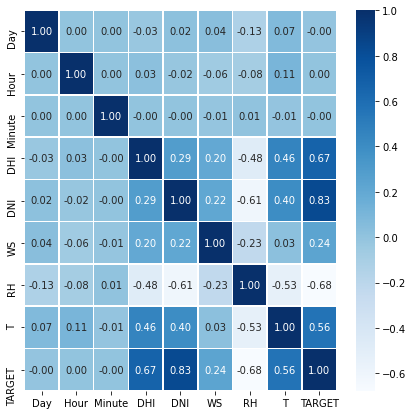

In [51]:
mask = (solar_data.Hour==12)&(solar_data.Minute==00)
solar_data_filtered = solar_data.loc[mask,:]
solar_data_filtered.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
plt.figure(figsize=(7, 7))
# sns.heatmap(data=solar_data_filtered.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
sns.heatmap(data=solar_data.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
solar_data.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)

In [3]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

def create_dataset(solar_data, index):
    dataX, dataY = [], []
    for i in range(0,48*7):
        dataX.append(list(np.array(solar_data.loc[index+i].tolist())))
    for i in range(48*7,48*7+48*2):
        dataY.append(solar_data.loc[index+i,'TARGET'])
    return np.array(dataX), np.array(dataY)

In [12]:
# 데이터셋 생성
input_data, output_data = [], []

last_index = 3*365*48-48*9
list_index = list(range(0,last_index,48))

# last_index = 3*365*48 - 432
# list_index = list(0:last_index,1))

for i in list_index:
    X, Y = create_dataset(solar_data,i)
    input_data.append(X)
    output_data.append(Y)

In [13]:
input_array = np.array(input_data)
output_array = np.reshape(np.array(output_data),(1086,96,1))

In [14]:
input_array.shape, output_array.shape

((1086, 336, 6), (1086, 96, 1))

In [15]:
# 데이터셋 분배
train_x, test_x, train_y, test_y = train_test_split(input_array, output_array, test_size = 0.1,shuffle = False)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1,shuffle=False)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# train_x = train_x.reshape((train_x.shape[0], 7, 1, 48, 6))

In [16]:
print(train_x.shape,train_y.shape)

(879, 336, 6) (879, 96, 1)


In [ ]:
	model = Sequential()
	model.add(LSTM(1048, activation='relu', input_shape=(336, 6)))
	model.add(Dense(256, activation='relu'))
	model.add(Dense(96))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
123/123 [==============================] - 45s 356ms/step - loss: 20428.5544
Epoch 2/100
123/123 [==============================] - 44s 355ms/step - loss: 1076.7567
Epoch 3/100
123/123 [==============================] - 44s 355ms/step - loss: 1060.4737
Epoch 4/100
123/123 [==============================] - 44s 358ms/step - loss: 1021.5069
Epoch 5/100
123/123 [==============================] - 44s 356ms/step - loss: 986.7109
Epoch 6/100
123/123 [==============================] - 44s 356ms/step - loss: 1007.0980
Epoch 7/100
123/123 [==============================] - 44s 360ms/step - loss: 1005.9595
Epoch 8/100
123/123 [==============================] - 44s 354ms/step - loss: 1022.9938
Epoch 9/100
123/123 [==============================] - 44s 355ms/step - loss: 1023.5692
Epoch 10/100
123/123 [==============================] - 44s 354ms/step - loss: 1023.1452
Epoch 11/100
123/123 [==============================] - 43s 352ms/step - loss: 997.9941
Epoch 12/100
123/123 [=========

In [ ]:
# 모델 사용하기
xhat = test_x[2]
print(xhat)
print(xhat.shape)
prediction = model.predict(np.array([xhat]), batch_size=1)
print(prediction)
print(prediction.shape)
print(max(prediction[0]))

[[ 0.    0.    2.4  62.11 13.    0.  ]
 [ 0.    0.    2.3  62.09 13.    0.  ]
 [ 0.    0.    2.2  59.43 13.    0.  ]
 ...
 [ 0.    0.    1.2  58.26 14.    0.  ]
 [ 0.    0.    1.3  57.19 14.    0.  ]
 [ 0.    0.    1.3  57.19 13.    0.  ]]
(336, 6)
[[ 1.78972241e-34 -2.05262964e-34 -2.11686581e-34 -1.97395417e-34
   1.93304742e-34  2.02863509e-34 -2.03251927e-34  2.05966401e-34
  -2.02997244e-34  1.38574116e-34  4.93683964e-01  2.28831315e+00
   5.31586504e+00  8.02067757e+00  1.01801491e+01  1.09812775e+01
   1.14030733e+01  1.16627073e+01  1.16493378e+01  1.18145208e+01
   1.19134378e+01  1.17452240e+01  1.18858719e+01  1.19335699e+01
   1.18877764e+01  1.17725630e+01  1.18658466e+01  1.18201456e+01
   1.17904921e+01  1.15942297e+01  1.15990591e+01  1.14418840e+01
   1.11444235e+01  1.04738026e+01  8.64311886e+00  6.67635536e+00
   4.07305813e+00  1.78613305e+00  4.58744407e-01 -2.12024398e-34
   1.11422469e-34  1.99756002e-34  1.99852751e-34 -1.98158616e-34
  -2.16735444e-34 -2.0157

In [19]:
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, 336, 6), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, 336, 6), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(96))
model.compile(loss='mean_squared_error', optimizer='adam')
custom_hist = CustomHistory()
custom_hist.init()
for i in range(200):
    model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
    model.reset_states()

879/879 [==============================] - 24s 27ms/step - loss: 129.0820 - val_loss: 204.8374


In [40]:
# 모델 사용하기
xhat = test_x[5]
print(xhat)
print(xhat.shape)
prediction = model.predict(np.array([xhat]), batch_size=1)
print(prediction)
print(prediction.shape)
print(max(prediction[0]))

[[ 0.    0.    1.6  76.47 15.    0.  ]
 [ 0.    0.    2.4  76.44 15.    0.  ]
 [ 0.    0.    3.2  73.03 15.    0.  ]
 ...
 [ 0.    0.    1.   70.9  10.    0.  ]
 [ 0.    0.    1.2  70.17 10.    0.  ]
 [ 0.    0.    1.4  75.12  9.    0.  ]]
(336, 6)
[[-5.9844791e-03  3.1060642e-03  1.4320865e-03  2.1412538e-03
  -7.3897960e-03  2.9875897e-03  6.3731824e-04 -6.4301351e-03
  -1.1828507e-03  9.0052187e-03  2.1761496e-01  3.1192911e-01
   1.5931828e+00  5.0439730e+00  1.0814290e+01  1.8053198e+01
   2.6089720e+01  3.3704098e+01  4.1155373e+01  4.6622688e+01
   5.2593586e+01  5.5905701e+01  5.7935921e+01  5.8842575e+01
   5.8982971e+01  5.6928680e+01  5.4370750e+01  5.1647221e+01
   4.7679371e+01  4.1750568e+01  3.5218849e+01  2.9502922e+01
   2.2487139e+01  1.5735970e+01  9.5938511e+00  4.4166117e+00
   1.3151299e+00  5.7268858e-02 -7.6702982e-02  7.2133793e-03
  -8.0595342e-03 -9.1140973e-04 -4.2077785e-04  8.5468264e-04
  -2.7019740e-03 -1.1280932e-02 -7.3484830e-03  6.6146599e-03
  -9.65

In [28]:
xlabel=list(range(0,96))

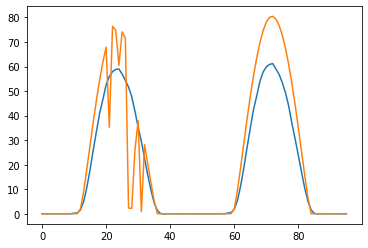

In [41]:
plt.plot(np.reshape(prediction,(96)))
plt.plot(test_y[5])

(1, 96)